#### Imports

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
import numpy as np
import ta
from os.path import exists
import re
import string
import nltk
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
import eco2ai
import difflib
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

In [10]:
# tracker = eco2ai.Tracker(project_name="hse_masters", file_name='emissions.csv')

## Twitter Data

### Dataset loading

Link to dataset: https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020

In [11]:
tweets_path = "Datasets/kaggle/Tweet.csv"
id_to_ticker_path = "Datasets/kaggle/Company_Tweet.csv"
ticker_to_name_path = "Datasets/kaggle/Company.csv"

#### Dataframe creation

We have 3 csv files: 
- Tweet.csv contains information about tweets (text, stats, unique id)
- Company_Tweet.csv mathches each unique id with a ticker symbol
- Company.csv matches company name with it's ticker symbol (some companies can have multipple tickers like $GOOG and $GOOGL for Google Inc.)

In [12]:
tweets_df = pd.read_csv(tweets_path)
tickers_df = pd.read_csv(id_to_ticker_path)
company_name_df = pd.read_csv(ticker_to_name_path)

In [13]:
tweets_df.post_date = pd.to_datetime(tweets_df.post_date, unit='s', origin='unix') # Converting to datetime
tweets_df.head(10)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
5,550443808606126081,aaplstocknews,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
6,550443809700851716,iknowfirst,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
7,550443857142611968,Cprediction,2015-01-01 00:10:16,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
8,550443857595600896,iknowfirst_br,2015-01-01 00:10:17,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
9,550443857692078081,Gold_prediction,2015-01-01 00:10:17,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


Here we can already see tweets with duplicate bodies, something to take care of in data cleaning step.

### Data exploration

In [14]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717964 entries, 0 to 3717963
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   tweet_id     int64         
 1   writer       object        
 2   post_date    datetime64[ns]
 3   body         object        
 4   comment_num  int64         
 5   retweet_num  int64         
 6   like_num     int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 198.6+ MB


In [15]:
tweets_df.shape

(3717964, 7)

In [16]:
tweets_df.nunique()

tweet_id       3717964
writer          140131
post_date      3421363
body           3326194
comment_num        191
retweet_num        509
like_num           783
dtype: int64

In [17]:
tweets_df.post_date.min(), tweets_df.post_date.max()

(Timestamp('2015-01-01 00:00:57'), Timestamp('2019-12-31 23:55:53'))

We have a total of 3.717.964 tweets in our dataset from 140.131 writers. This means that significant amount of tweets are written by the same accounts through the period from the beggining of 2015 to the end of 2019.

In [18]:
tweets_df.apply(lambda x: sum(x.isna()) / len(tweets_df))

tweet_id       0.000000
writer         0.012715
post_date      0.000000
body           0.000000
comment_num    0.000000
retweet_num    0.000000
like_num       0.000000
dtype: float64

Less than 1% of NaN values only in writer column.

In [19]:
# Top 20 writers by number of tweets
tweets_df.writer.value_counts()[:20]

App_sw_            91741
_peripherals       91461
computer_hware     90919
It_c0nsulting      75270
PortfolioBuzz      59838
retail_Dbt         44174
MacHashNews        42190
ExactOptionPick    22084
markbspiegel       18228
davidmoadel        15553
OACtrading         14432
SeekingAlpha       13970
treabase           13828
rosnerstocks       13461
PolgarStocks       13370
Commuternyc        13241
IHNewsDesk         13226
JohnyTradr         12419
TalkMarkets        11685
Benzinga           10791
Name: writer, dtype: int64

In [20]:
sum(tweets_df.writer.value_counts() == 1) # tweeted only once

77577

Number of tweets per week and date:

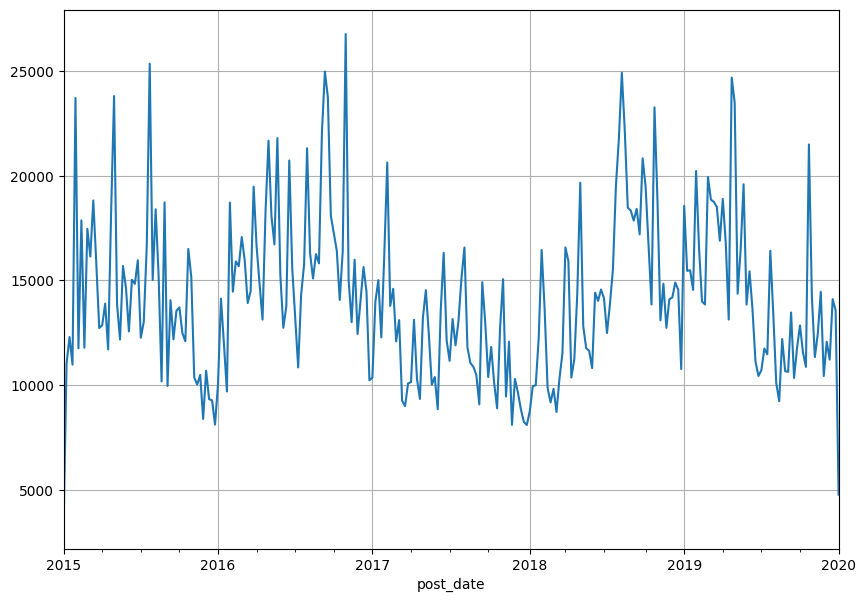

In [21]:
tweets_df.groupby(pd.Grouper(key='post_date', axis=0, freq='1w')).count()['tweet_id'].plot(grid=True, figsize=(10,7));

We can see that nearing the end of the year the number of tweets decreases, possiblu because of long holidays when the markets are closed.

Number of tweets to character length:

122.04350799384774

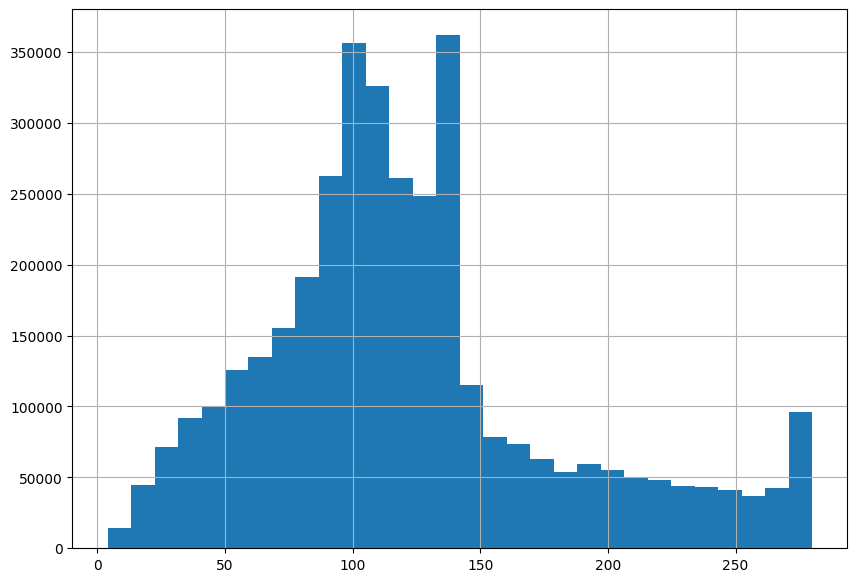

In [22]:
tweets_df.body.str.len()[tweets_df.body.str.len() <= 280].hist(bins=30, figsize=(10,7));
tweets_df.body.str.len()[tweets_df.body.str.len() <= 280].mean()

In order to combine datasets correctly we need to use inner join method, because for one tweet id we can have multiple tickers mentioned.

In [23]:
merged_df = pd.merge(tickers_df, tweets_df, how='inner')
merged_df = pd.merge(company_name_df, merged_df, how='inner')
merged_df['interactions'] = merged_df.comment_num + merged_df.retweet_num + merged_df.like_num
merged_df

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,interactions
0,AAPL,apple,550803612197457920,SentiQuant,2015-01-01 23:59:49,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,1
1,AAPL,apple,550803610825928706,SentiQuant,2015-01-01 23:59:48,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,1
2,AAPL,apple,550803225113157632,MacHashNews,2015-01-01 23:58:16,Rumor Roundup: What to expect when you're expe...,0,0,0,0
3,AAPL,apple,550802957370159104,WaltLightShed,2015-01-01 23:57:13,"An $AAPL store line in Sapporo Japan for the ""...",2,4,4,10
4,AAPL,apple,550802855129382912,2waystrading,2015-01-01 23:56:48,$AAPL - Will $AAPL Give Second entry opportuni...,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4336440,MSFT,Microsoft,1212122611192336394,LadeBackk,2019-12-31 21:25:25,$MSFT check the timestamp.... buy the dip and ...,0,1,3,4
4336441,MSFT,Microsoft,1212131912585826305,robintrack,2019-12-31 22:02:22,Top increases in popularity for stocks held by...,0,0,2,2
4336442,MSFT,Microsoft,1212145214736875520,MarketCurrents,2019-12-31 22:55:14,"$AAPL $MSFT $JPM - Apple, Microsoft top Dow 20...",0,0,2,2
4336443,MSFT,Microsoft,1212146425607413761,SentimEntropy,2019-12-31 23:00:03,Notable activity on social media recently for$...,0,0,0,0


In [24]:
merged_df.nunique()

ticker_symbol          6
company_name           5
tweet_id         3717964
writer            140131
post_date        3421363
body             3326194
comment_num          191
retweet_num          509
like_num             783
interactions        1018
dtype: int64

In [25]:
tweets_df.nunique()

tweet_id       3717964
writer          140131
post_date      3421363
body           3326194
comment_num        191
retweet_num        509
like_num           783
dtype: int64

Number of unique values has not changed - merge was correct.

Now let's explore the merged dataframe:

In [26]:
def merge_chart_make(arg, title, aggregator=None):
    if aggregator == 'sum':
        merged_df.groupby(['company_name', pd.Grouper(key='post_date', freq='W')]).sum().reset_index().pivot(
        'post_date','company_name',arg).plot(title=title, grid=True, figsize=(17,7))
    else:
        merged_df.groupby(['company_name', pd.Grouper(key='post_date', freq='W')]).count().reset_index().pivot(
        'post_date','company_name',arg).plot(title=title, grid=True, figsize=(17,7))

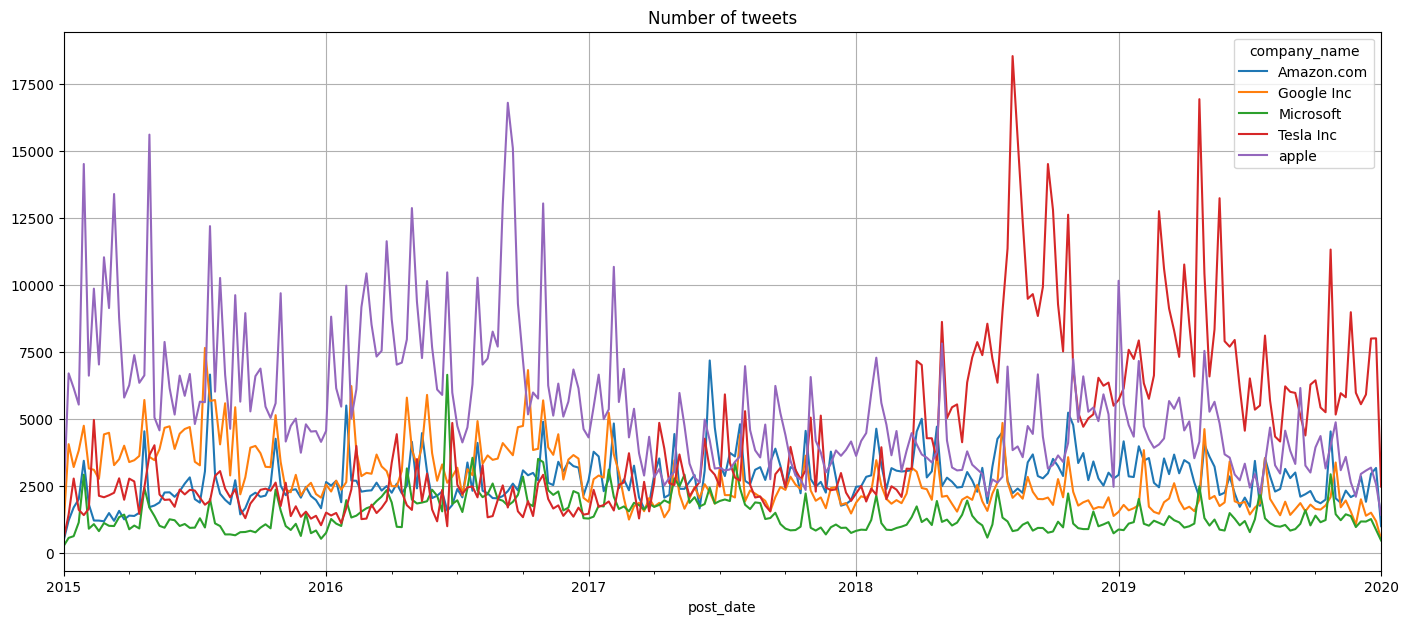

In [27]:
merge_chart_make(arg='tweet_id', title='Number of tweets');

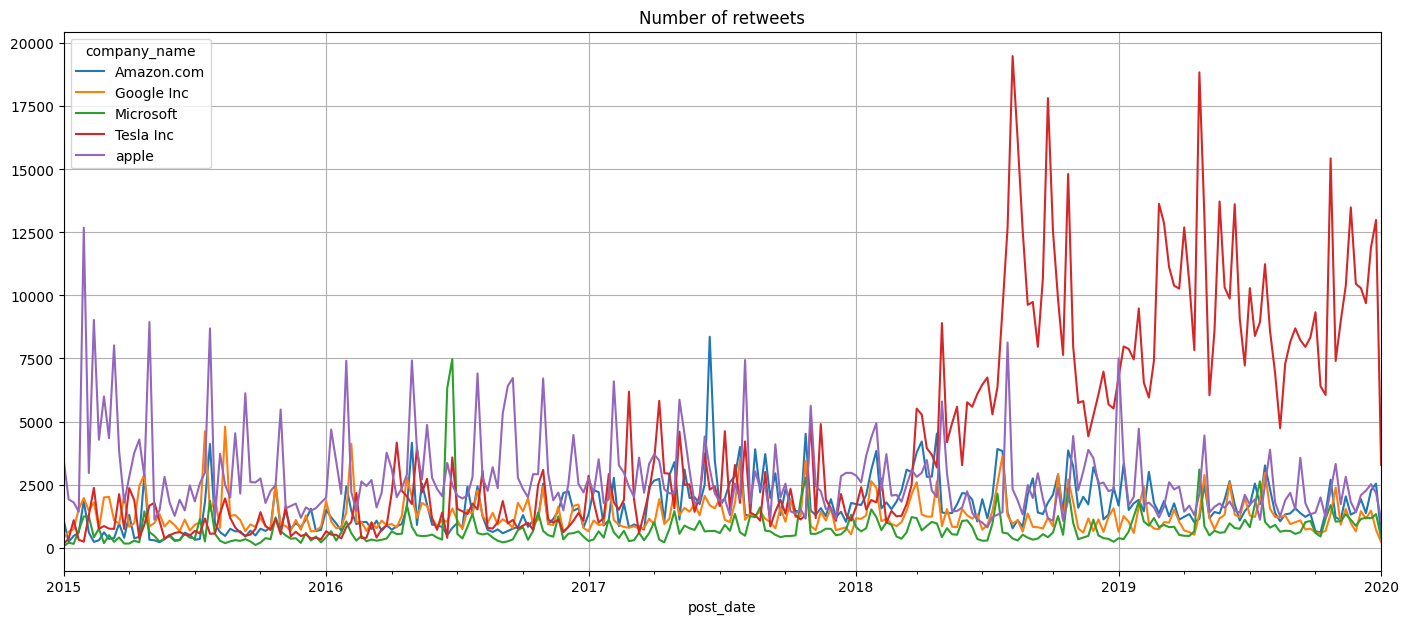

In [28]:
merge_chart_make(arg='retweet_num', title='Number of retweets', aggregator='sum');

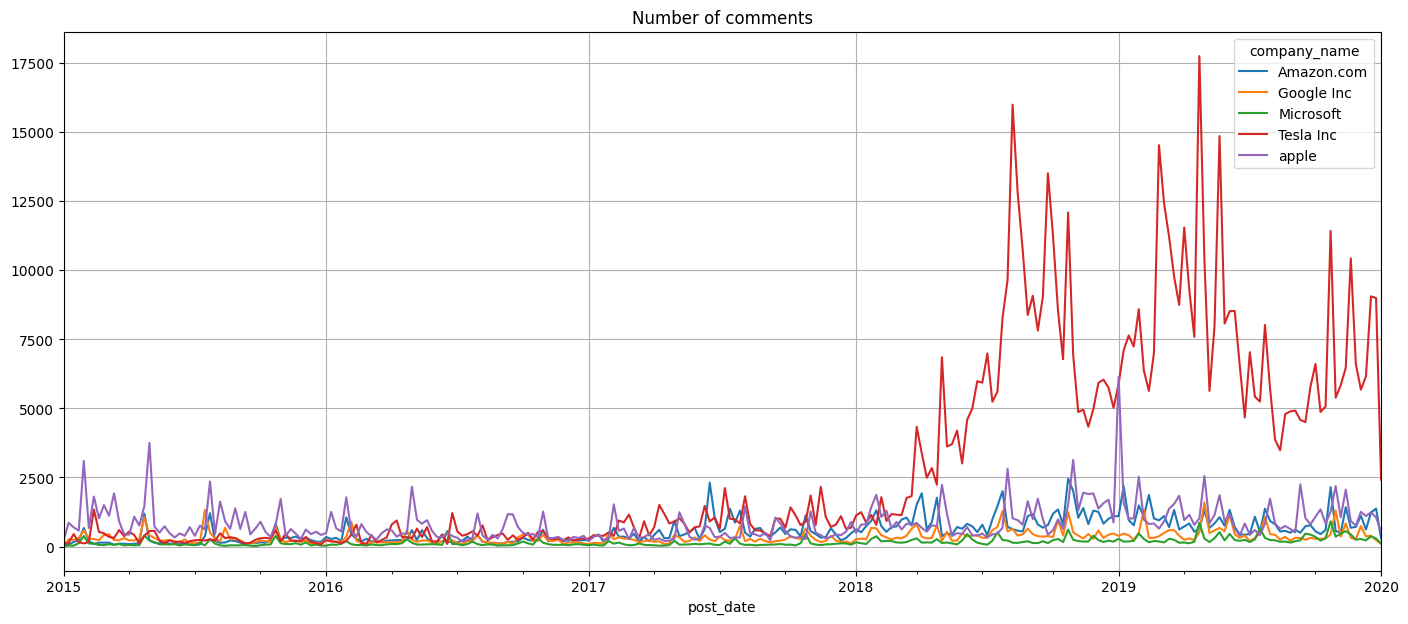

In [29]:
merge_chart_make(arg='comment_num', title='Number of comments', aggregator='sum');

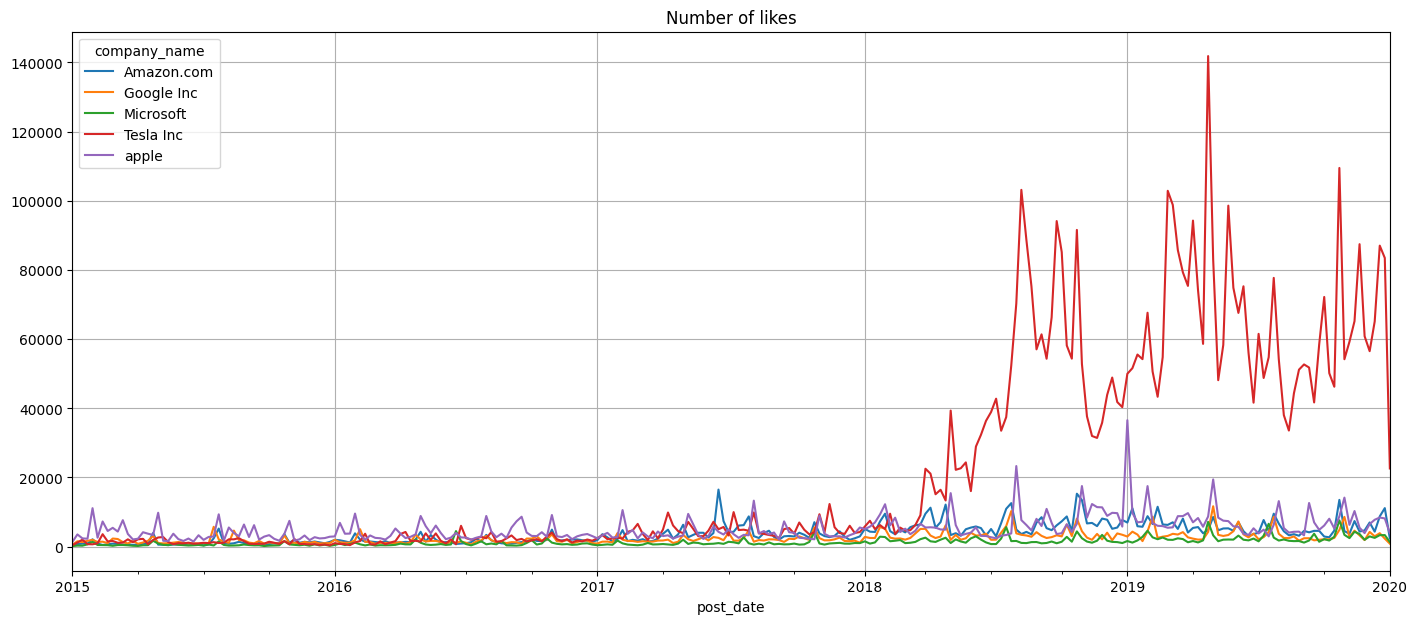

In [30]:
merge_chart_make(arg='like_num', title='Number of likes', aggregator='sum');

## Yahoo Data

In [31]:
def create_price_graph():
    AAPL = AAPL_stock.Close
    GOOG = GOOG_stock.Close
    GOOGL = GOOGL_stock.Close
    AMZN = AMZN_stock.Close
    TSLA = TSLA_stock.Close

    # Plot everything by leveraging the very powerful matplotlib package
    fig, ax = plt.subplots(figsize=(10,7))

    ax.grid()
    ax.set_title("Daily close price")

    ax.plot(AAPL.index, AAPL, label='AAPL')
    ax.plot(GOOG.index, GOOG, label='GOOG')
    ax.plot(GOOGL.index, GOOGL, label='GOOGL')
    ax.plot(AMZN.index, AMZN, label='AMZN')
    ax.plot(TSLA.index, TSLA, label='TSLA')

    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted closing price ($)')

    ax.legend()

In [32]:
def create_volume_graph():
    AAPL = AAPL_stock.groupby(pd.Grouper(freq='W')).sum()['Volume']
    GOOG = GOOG_stock.groupby(pd.Grouper(freq='W')).sum()['Volume']
    GOOGL = GOOGL_stock.groupby(pd.Grouper(freq='W')).sum()['Volume']
    AMZN = AMZN_stock.groupby(pd.Grouper(freq='W')).sum()['Volume']
    TSLA = TSLA_stock.groupby(pd.Grouper(freq='W')).sum()['Volume']

    # Plot everything by leveraging the very powerful matplotlib package
    fig, ax = plt.subplots(figsize=(10,7))

    ax.grid()
    ax.set_title("Daily volume")

    ax.bar(AAPL.index, AAPL, label='AAPL', width=5)
    ax.bar(TSLA.index, TSLA, label='TSLA', width=5)
    ax.bar(AMZN.index, AMZN, label='AMZN', width=5)
    ax.bar(GOOGL.index, GOOGL, label='GOOGL', width=5)
    ax.bar(GOOG.index, GOOG, label='GOOG', width=5)

    ax.set_xlabel('Date')
    ax.set_ylabel('Volume')

    ax.legend()

In [33]:
tickers = company_name_df.ticker_symbol.tolist()
tickers

['AAPL', 'GOOG', 'GOOGL', 'AMZN', 'TSLA', 'MSFT']

### APPL

In [34]:
# if exists("Datasets/yfinance/AAPL.csv"):
#     AAPL_stock = pd.read_csv("Datasets/yfinance/AAPL.csv", index_col='Date')
# else:
#     AAPL_stock = yf.Ticker(tickers[0]).history(start="2015-01-01", end="2020-01-01")
#     AAPL_stock.index = AAPL_stock.index.normalize()
#     AAPL_stock.to_csv(f"Datasets/yfinance/{tickers[0]}.csv")

# AAPL_stock.index = pd.to_datetime(AAPL_stock.index)
# AAPL_stock.head()

In [35]:
AAPL_stock = yf.Ticker(tickers[0]).history(start="2015-01-01", end="2020-01-01")
AAPL_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,25.066781,25.078033,24.157634,24.603207,212818400,0.0,0
2015-01-05 00:00:00-05:00,24.369161,24.450175,23.721058,23.910088,257142000,0.0,0
2015-01-06 00:00:00-05:00,23.975356,24.175638,23.545536,23.912346,263188400,0.0,0
2015-01-07 00:00:00-05:00,24.123876,24.348912,24.011358,24.247646,160423600,0.0,0
2015-01-08 00:00:00-05:00,24.580701,25.237806,24.461431,25.179296,237458000,0.0,0


In [36]:
AAPL_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 00:00:00-05:00 to 2019-12-31 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1258 non-null   float64
 1   High          1258 non-null   float64
 2   Low           1258 non-null   float64
 3   Close         1258 non-null   float64
 4   Volume        1258 non-null   int64  
 5   Dividends     1258 non-null   float64
 6   Stock Splits  1258 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 78.6 KB


### GOOG

In [37]:
# if exists("Datasets/yfinance/GOOG.csv"):
#     GOOG_stock = pd.read_csv("Datasets/yfinance/GOOG.csv", index_col='Date')
# else:
#     GOOG_stock = yf.Ticker(tickers[1]).history(start="2015-01-01", end="2020-01-01")
#     GOOG_stock.index = GOOG_stock.index.normalize()
#     GOOG_stock.to_csv(f"Datasets/yfinance/{tickers[1]}.csv")

# GOOG_stock.head()

In [38]:
GOOG_stock = yf.Ticker(tickers[1]).history(start="2015-01-01", end="2020-01-01")
GOOG_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,26.378078,26.490770,26.133251,26.168653,28951268,0,0.0
2015-01-05 00:00:00-05:00,26.091366,26.144720,25.582764,25.623152,41196796,0,0.0
2015-01-06 00:00:00-05:00,25.679497,25.738087,24.983908,25.029282,57998800,0,0.0
2015-01-07 00:00:00-05:00,25.280592,25.292759,24.914099,24.986401,41301082,0,0.0
2015-01-08 00:00:00-05:00,24.831326,25.105074,24.482782,25.065184,67071641,0,0.0


In [39]:
GOOG_stock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.000000
mean,45.666494,46.054933,45.277309,45.680669,3.413936e+07,0.0,0.000797
std,11.533924,11.639594,11.452816,11.550799,1.697264e+07,0.0,0.028272
min,24.664783,24.730902,24.311253,24.560070,6.950000e+06,0.0,0.000000
25%,36.463751,36.745375,36.125436,36.466002,2.425600e+07,0.0,0.000000
50%,46.486500,46.715250,46.176624,46.473249,2.976300e+07,0.0,0.000000
75%,55.632999,56.213625,55.222587,55.760251,3.898500e+07,0.0,0.000000
max,68.167503,68.250000,67.633499,68.058502,2.232980e+08,0.0,1.002746


### GOOGL

In [40]:
# if exists("Datasets/yfinance/GOOGL.csv"):
#     GOOGL_stock = pd.read_csv("Datasets/yfinance/GOOGL.csv", index_col='Date')
# else:
#     GOOGL_stock = yf.Ticker(tickers[2]).history(start="2015-01-01", end="2020-01-01")
#     GOOGL_stock.index = GOOGL_stock.index.normalize()
#     GOOGL_stock.to_csv(f"Datasets/yfinance/{tickers[2]}.csv")

# GOOGL_stock.head()

In [41]:
GOOGL_stock = yf.Ticker(tickers[2]).history(start="2015-01-01", end="2020-01-01")
GOOGL_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,26.629999,26.790001,26.393999,26.477501,26480000,0,0
2015-01-05 00:00:00-05:00,26.357500,26.399500,25.887501,25.973000,41182000,0,0
2015-01-06 00:00:00-05:00,26.025000,26.060499,25.277500,25.332001,54456000,0,0
2015-01-07 00:00:00-05:00,25.547501,25.574499,25.182501,25.257500,46918000,0,0
2015-01-08 00:00:00-05:00,25.075500,25.375000,24.750999,25.345501,73054000,0,0


In [42]:
GOOGL_stock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.0
mean,46.350680,46.741645,45.939285,46.354110,3.726109e+07,0.0,0.0
std,11.287292,11.386466,11.200538,11.298248,1.885330e+07,0.0,0.0
min,24.962000,25.014000,24.545500,24.853001,1.041200e+07,0.0,0.0
25%,37.448502,37.749876,37.078999,37.479752,2.625400e+07,0.0,0.0
50%,47.366251,47.636999,47.002499,47.377249,3.269300e+07,0.0,0.0
75%,55.950376,56.560374,55.556499,56.019501,4.199000e+07,0.0,0.0
max,68.199997,68.352501,67.650002,68.123497,2.571620e+08,0.0,0.0


### AMZN

In [43]:
# if exists("Datasets/yfinance/AMZN.csv"):
#     AMZN_stock = pd.read_csv("Datasets/yfinance/AMZN.csv", index_col='Date')
# else:
#     AMZN_stock = yf.Ticker(tickers[3]).history(start="2015-01-01", end="2020-01-01")
#     AMZN_stock.index = AMZN_stock.index.normalize()
#     AMZN_stock.to_csv(f"Datasets/yfinance/{tickers[3]}.csv")

AMZN_stock = yf.Ticker(tickers[3]).history(start="2015-01-01", end="2020-01-01")
AMZN_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,15.6290,15.7375,15.3480,15.4260,55664000,0,0
2015-01-05 00:00:00-05:00,15.3505,15.4190,15.0425,15.1095,55484000,0,0
2015-01-06 00:00:00-05:00,15.1120,15.1500,14.6190,14.7645,70380000,0,0
2015-01-07 00:00:00-05:00,14.8750,15.0640,14.7665,14.9210,52806000,0,0
2015-01-08 00:00:00-05:00,15.0160,15.1570,14.8055,15.0230,61768000,0,0


In [44]:
AMZN_stock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.0
mean,55.774627,56.274166,55.177382,55.752367,8.380145e+07,0.0,0.0
std,26.625267,26.851819,26.321770,26.596442,4.501685e+07,0.0,0.0
min,14.314000,14.539500,14.262500,14.347500,1.762600e+07,0.0,0.0
25%,33.284624,33.747499,32.969000,33.239624,5.472550e+07,0.0,0.0
50%,48.577499,48.818001,48.073252,48.394751,7.147900e+07,0.0,0.0
75%,84.037502,84.998751,83.074999,83.847622,9.746950e+07,0.0,0.0
max,101.905502,102.525002,100.650002,101.975502,4.771220e+08,0.0,0.0


### TSLA

In [45]:
# if exists("Datasets/yfinance/TSLA.csv"):
#     TSLA_stock = pd.read_csv("Datasets/yfinance/TSLA.csv", index_col='Date')
# else:
#     TSLA_stock = yf.Ticker(tickers[4]).history(start="2015-01-01", end="2020-01-01")
#     TSLA_stock.index = TSLA_stock.index.normalize()
#     TSLA_stock.to_csv(f"Datasets/yfinance/{tickers[4]}.csv")

TSLA_stock = yf.Ticker(tickers[4]).history(start="2015-01-01", end="2020-01-01")
TSLA_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,14.858000,14.883333,14.217333,14.620667,71466000,0,0
2015-01-05 00:00:00-05:00,14.303333,14.433333,13.810667,14.006000,80527500,0,0
2015-01-06 00:00:00-05:00,14.004000,14.280000,13.614000,14.085333,93928500,0,0
2015-01-07 00:00:00-05:00,14.223333,14.318667,13.985333,14.063333,44526000,0,0
2015-01-08 00:00:00-05:00,14.187333,14.253333,14.000667,14.041333,51637500,0,0


In [46]:
TSLA_stock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.0
mean,17.920343,18.216395,17.613923,17.927925,9.908941e+07,0.0,0.0
std,3.737105,3.794986,3.677695,3.742651,6.235988e+07,0.0,0.0
min,9.488000,10.331333,9.403333,9.578000,1.062000e+07,0.0,0.0
25%,14.797833,15.008333,14.535500,14.724167,5.993175e+07,0.0,0.0
50%,17.174334,17.480000,16.888333,17.185000,8.286375e+07,0.0,0.0
75%,21.078167,21.465167,20.719667,21.111834,1.175944e+08,0.0,0.0
max,29.000000,29.020666,28.423332,28.729334,5.047455e+08,0.0,0.0


In [47]:
# if exists("Datasets/yfinance/MSFT.csv"):
#     MSFT_stock = pd.read_csv("Datasets/yfinance/MSFT.csv", index_col='Date')
# else:
#     MSFT_stock = yf.Ticker(tickers[5]).history(start="2015-01-01", end="2020-01-01")
#     MSFT_stock.index = MSFT_stock.index.normalize()
#     MSFT_stock.to_csv(f"Datasets/yfinance/{tickers[5]}.csv")

MSFT_stock = yf.Ticker(tickers[5]).history(start="2015-01-01", end="2020-01-01")
MSFT_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,40.724151,41.387466,40.619418,40.811428,27913900,0.0,0
2015-01-05 00:00:00-05:00,40.471043,40.785246,40.366310,40.436134,39673900,0.0,0
2015-01-06 00:00:00-05:00,40.479769,40.802698,39.746629,39.842636,36447900,0.0,0
2015-01-07 00:00:00-05:00,40.130673,40.549610,39.703010,40.348869,29114100,0.0,0
2015-01-08 00:00:00-05:00,40.802707,41.675492,40.776525,41.535847,29645200,0.0,0


In [48]:
MSFT_stock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000,1258.0
mean,76.118384,76.723762,75.451167,76.130480,2.912099e+07,0.006328,0.0
std,32.300696,32.499515,32.008074,32.276086,1.396202e+07,0.050272,0.0
min,35.426348,35.810310,35.112145,35.260513,7.425600e+06,0.000000,0.0
25%,47.919201,48.401343,47.612143,48.149858,2.068352e+07,0.000000,0.0
50%,66.049247,66.636446,65.517982,66.184410,2.594710e+07,0.000000,0.0
75%,101.679146,102.747008,100.512766,101.643225,3.333992e+07,0.000000,0.0
max,155.014492,155.111716,153.818711,154.538132,1.691640e+08,0.510000,0.0


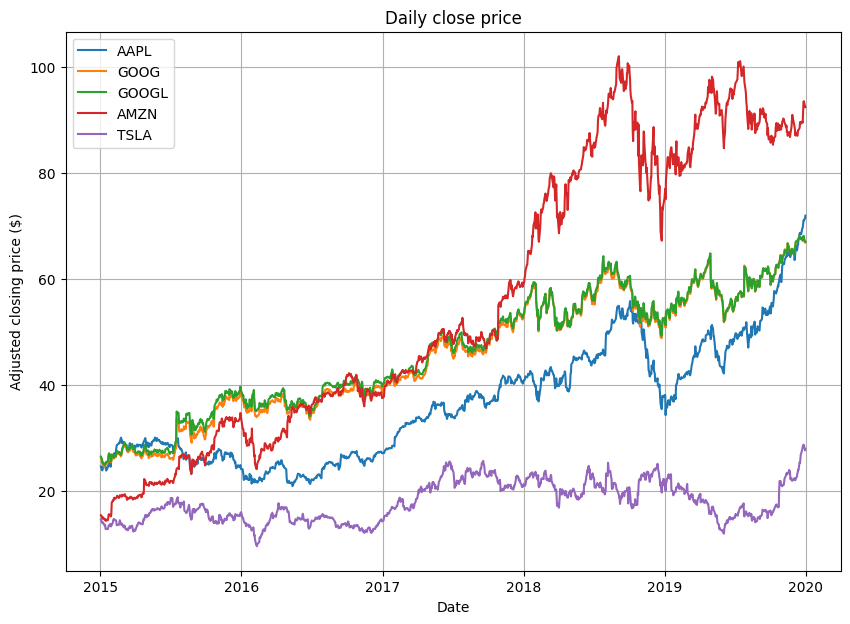

In [49]:
create_price_graph()

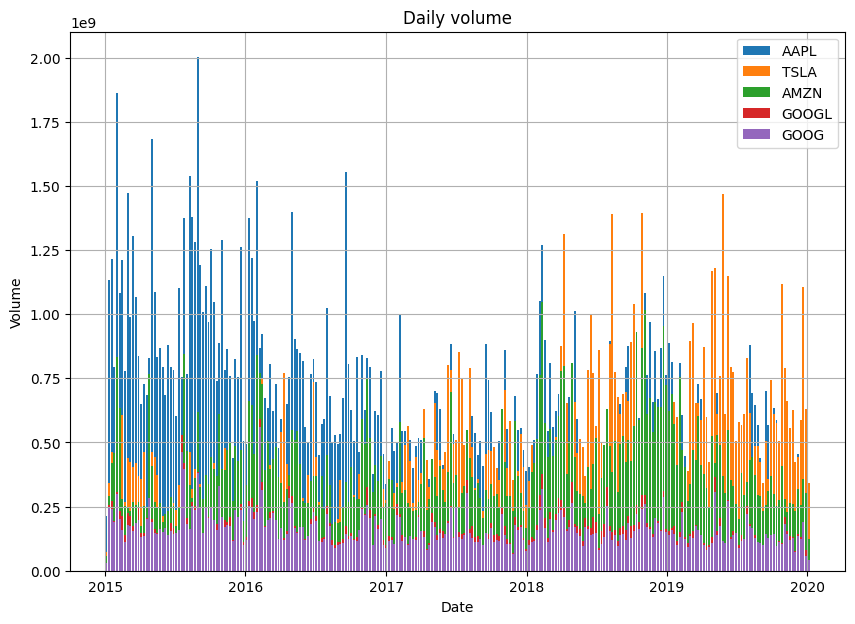

In [50]:
create_volume_graph()

## Combined

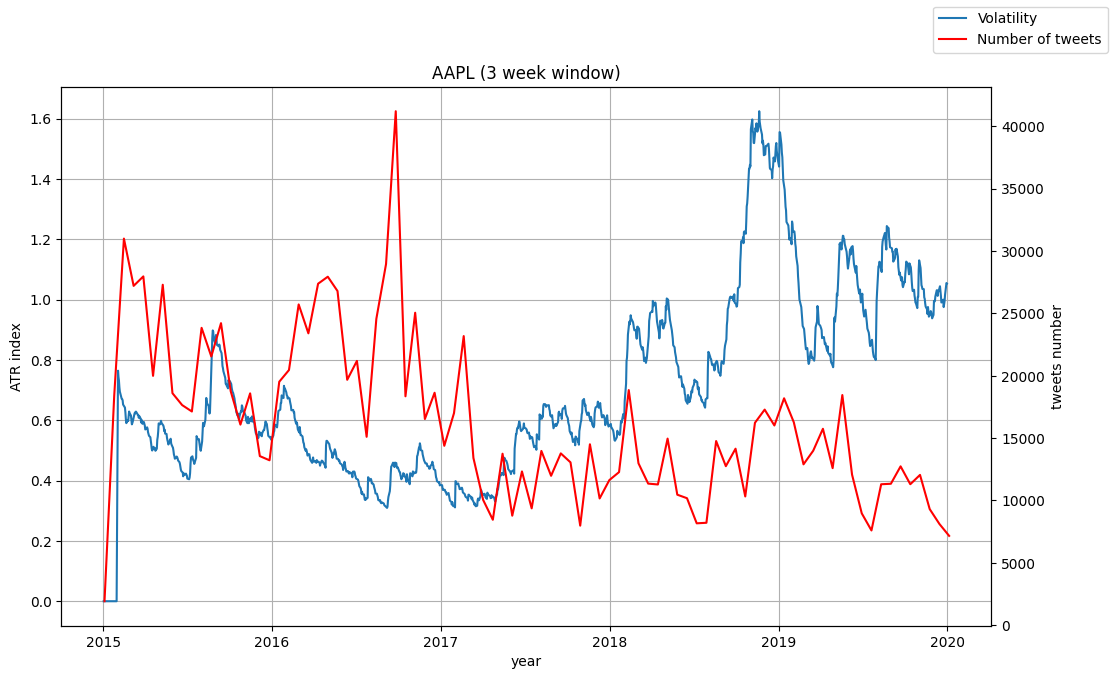

In [51]:
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(ta.volatility.AverageTrueRange(
    high=AAPL_stock.High, low=AAPL_stock.Low, close=AAPL_stock.Close, window=21).average_true_range(), label='Volatility')
ax.set_title('AAPL (3 week window)')
ax.set_xlabel('year')
ax.set_ylabel('ATR index')
ax2 = ax.twinx()
ax2.plot(merged_df[merged_df.ticker_symbol == 'AAPL'].groupby(pd.Grouper(
    key='post_date', axis=0, freq='3w')).count()['tweet_id'], color='r', label='Number of tweets')
ax2.set_ylabel('tweets number')
ax.grid()
fig.legend()
plt.show();

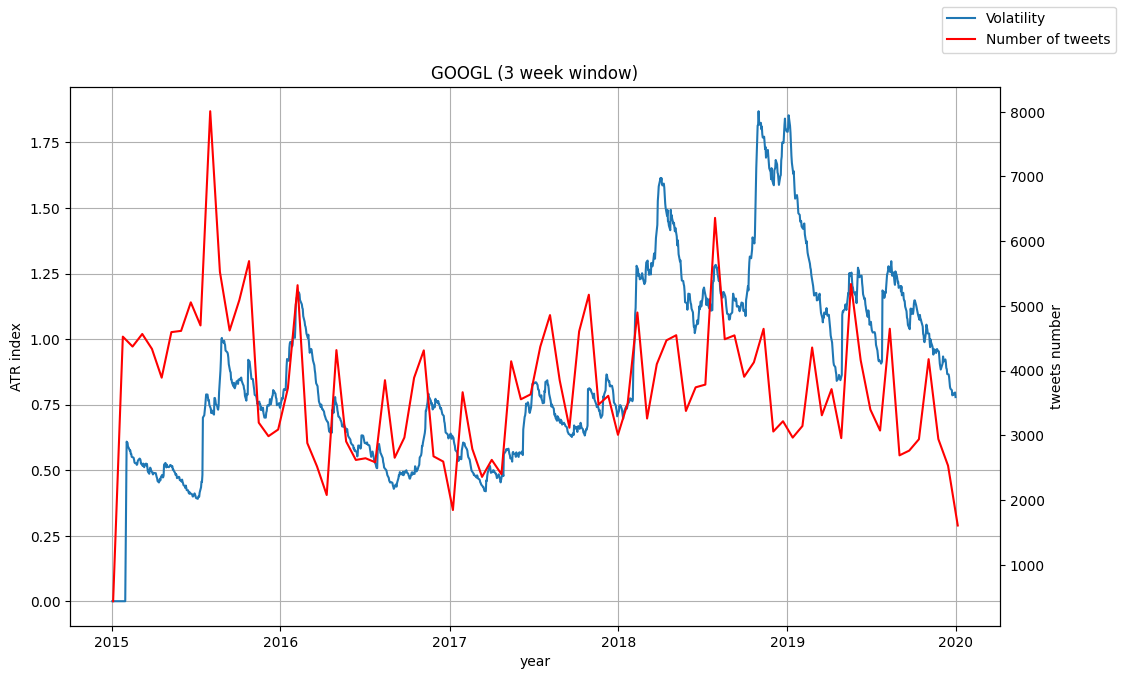

In [52]:
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(ta.volatility.AverageTrueRange(
    high=GOOGL_stock.High, low=GOOGL_stock.Low, close=GOOGL_stock.Close, window=21).average_true_range(), label='Volatility')
ax.set_title('GOOGL (3 week window)')
ax.set_xlabel('year')
ax.set_ylabel('ATR index')
ax2 = ax.twinx()
ax2.plot(merged_df[merged_df.ticker_symbol == 'GOOGL'].groupby(pd.Grouper(
    key='post_date', axis=0, freq='3w')).count()['tweet_id'], color='r', label='Number of tweets')
ax2.set_ylabel('tweets number')
ax.grid()
fig.legend()
plt.show();

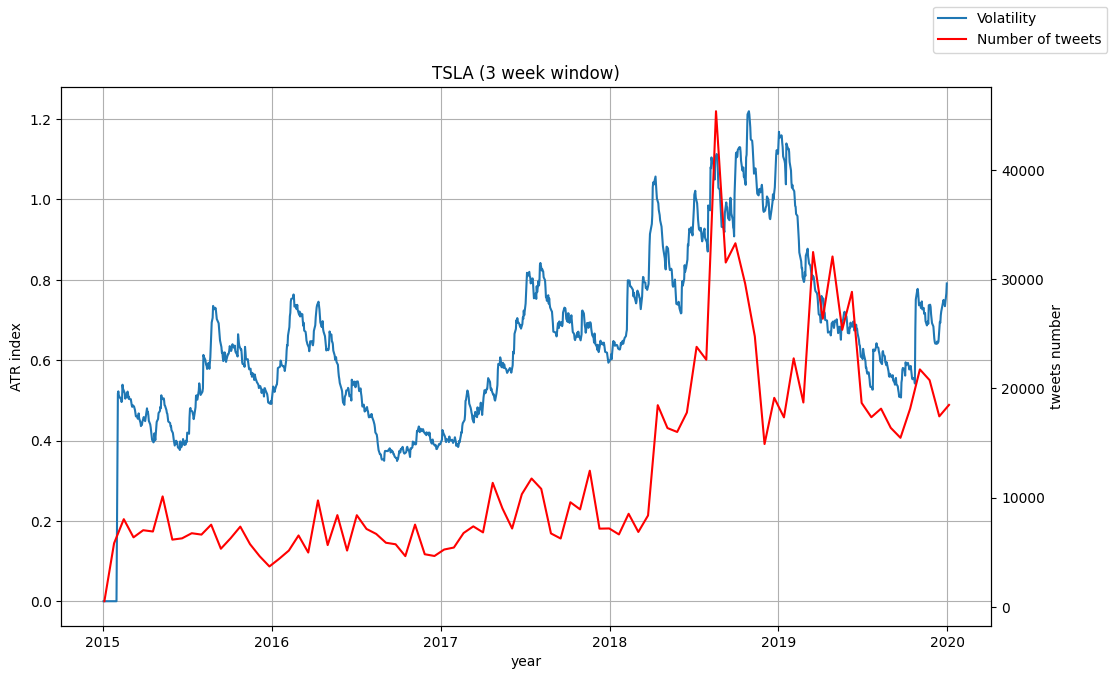

In [53]:
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(ta.volatility.AverageTrueRange(
    high=TSLA_stock.High, low=TSLA_stock.Low, close=TSLA_stock.Close, window=21).average_true_range(), label='Volatility')
ax.set_title('TSLA (3 week window)')
ax.set_xlabel('year')
ax.set_ylabel('ATR index')
ax2 = ax.twinx()
ax2.plot(merged_df[merged_df.ticker_symbol == 'TSLA'].groupby(pd.Grouper(
    key='post_date', axis=0, freq='3w')).count()['tweet_id'], color='r', label='Number of tweets')
ax2.set_ylabel('tweets number')

ax.grid()
fig.legend()
plt.show();

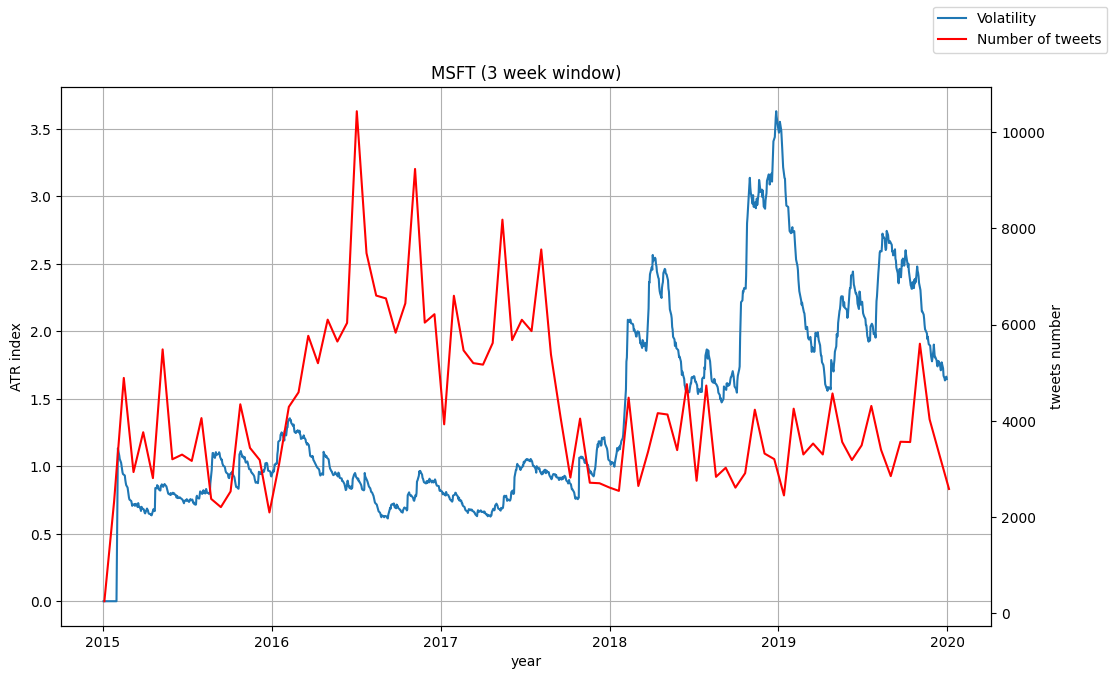

In [54]:
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(ta.volatility.AverageTrueRange(
    high=MSFT_stock.High, low=MSFT_stock.Low, close=MSFT_stock.Close, window=21).average_true_range(), label='Volatility')
ax.set_title('MSFT (3 week window)')
ax.set_xlabel('year')
ax.set_ylabel('ATR index')
ax2 = ax.twinx()
ax2.plot(merged_df[merged_df.ticker_symbol == 'MSFT'].groupby(pd.Grouper(
    key='post_date', axis=0, freq='3w')).count()['tweet_id'], color='r', label='Number of tweets')
ax2.set_ylabel('tweets number')
ax.grid()
fig.legend()
plt.show();

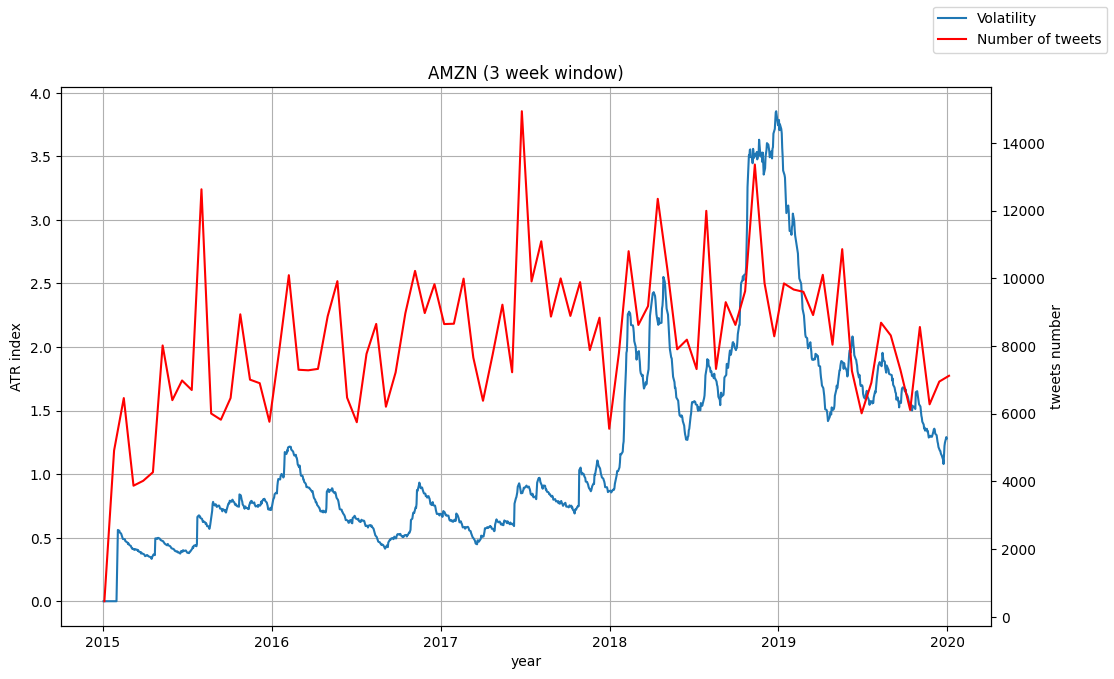

In [55]:
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(ta.volatility.AverageTrueRange(
    high=AMZN_stock.High, low=AMZN_stock.Low, close=AMZN_stock.Close, window=21).average_true_range(), label='Volatility')
ax.set_title('AMZN (3 week window)')
ax.set_xlabel('year')
ax.set_ylabel('ATR index')
ax2 = ax.twinx()
ax2.plot(merged_df[merged_df.ticker_symbol == 'AMZN'].groupby(pd.Grouper(
    key='post_date', axis=0, freq='3w')).count()['tweet_id'], color='r', label='Number of tweets')
ax2.set_ylabel('tweets number')
ax.grid()
fig.legend()
plt.show();

## Data cleaning

First we remove the tweets with more than 1 stock mentioned to prevent further problems with this cases:

In [56]:
single_stock = tickers_df.tweet_id.value_counts()
single_stock = pd.Series(single_stock[single_stock == 1].index)

In [57]:
clean_tweets = tweets_df[tweets_df.tweet_id.isin(single_stock)]
print(tweets_df.shape[0] - clean_tweets.shape[0], "tweets were removed")

421101 tweets were removed


Now let's remove duplicate tweeets, but let's save the interactions data in the process

In [58]:
interactions_agg = clean_tweets.groupby(['body'])['comment_num', 'retweet_num', 'like_num'].sum()

In [59]:
interactions_agg[:5]

,comment_num,retweet_num,like_num
body,,,
"$tsla ***TESLA ANNOUNCES ENTERING CREDIT RATING BUSINESS***ISSUES TTT RATING ON $TSLA EQUITY, STABLE OUTLOOK",1,0,24
#ElectricVehicle fr the Masses #Tesla #TelsaModel3 $TSLA #emoji,0,0,1
420 FUNDING SECURED$TSLA @elonmusk,0,0,2
@elonmusk #Tesla #TSLA $TSLA $TSLAQElon gave you plenty of noticeYou thought you were smarterAnd now you will be squeezed,1,0,1
@elonmusk #Tesla #TSLA $TSLA $TSLAQTesla skeptics & haters/shortsElon gave you plenty of notice,5,16,199


In [60]:
clean_tweets = pd.merge(clean_tweets, interactions_agg, on=['body']).drop(
    columns=['comment_num_x', 'retweet_num_x', 'like_num_x'])

In [61]:
clean_tweets.rename(columns={
    'comment_num_y': 'comment_num',
    'retweet_num_y': 'retweet_num',
    'like_num_y': 'like_num'
    }, inplace=True)

In [62]:
print("Before :", clean_tweets.shape[0])
clean_tweets = clean_tweets.drop_duplicates(subset=["body"])
print("After :", clean_tweets.shape[0])
clean_tweets.reset_index(drop=True, inplace=True);

Before : 3296863
After : 2990337


Preprocessing functions:

In [63]:
def clean_text(tweet):
    tweet = re.sub(r'^RT[\s]+', ' ', tweet) # remove rt tag
    tweet = re.sub(r'#', ' ', tweet) # remove hashtag symbols
    tweet = re.sub(r'\$[A-Za-z]+', ' ', tweet) # remove tickers
    tweet = re.sub(r'[!"“”#$%\'()*+,-./:;<=>?@\\^_`{|}~]', ' ', tweet) # remove punctuation
    tweet = re.sub(r"’", ' ', tweet) # remove punctuation
    tweet = re.sub(r"[�]", ' ', tweet) # remove unknown
    # tweet = re.sub(r'[0-9]+', '', tweet)
    tweet = re.sub(r'\s{2,}', ' ', tweet) # remove extra whitespaces
    return tweet

def replace_contraction(tweet):
    tweet = re.sub(r'http[s]?://\S+', '', tweet) # remove links (caused problems so had to move here)
    tweet = re.sub(r'[?<=^|\s](\w*-?\w+\.[a-z]{2,}\S*)', '', tweet) # remove links
    tweet = re.sub(r"won\'t", "will not", tweet)
    tweet = re.sub(r"can\'t", "can not", tweet)
    tweet = re.sub(r"n\'t", " not", tweet)
    tweet = re.sub(r"\'re", " are", tweet)
    tweet = re.sub(r"\'s", " is", tweet)
    tweet = re.sub(r"\'d", " would", tweet)
    tweet = re.sub(r"\'ll", " will", tweet)
    tweet = re.sub(r"\'t", " not", tweet)
    tweet = re.sub(r"\'ve", " have", tweet)
    tweet = re.sub(r"\'m", " am", tweet)
    return tweet

In [64]:
if exists('Datasets/results/preprocessed.pkl'):
    preprocessed = pd.read_pickle("Datasets/results/preprocessed.pkl")
else:
    preprocessed = clean_tweets.body.apply(lambda tweet: replace_contraction(tweet))
    preprocessed = preprocessed.apply(lambda tweet: clean_text(tweet))
    preprocessed = preprocessed.apply(lambda tweet: tweet.lower().strip())
    preprocessed.to_pickle("Datasets/results/preprocessed.pkl")

In [65]:
compare = pd.DataFrame(columns=['original', 'preprocessed'])
compare.original = clean_tweets.body
compare.preprocessed = preprocessed
compare = compare.reset_index().drop('index', axis=1)

In [66]:
def comparison(x):
    print(compare.original[x])
    print(compare.preprocessed[x])

In [67]:
comparison(31875)

$AAPL 9 min til power hour....
9 min til power hour


In [68]:
comparison(0)

lx21 made $10,008  on $AAPL -Check it out! http://profit.ly/1MnD8s?aff=202 Learn #howtotrade http://bit.ly/1c1NljX $EXE $WATT $IMRS $CACH $GMO
lx21 made 10 008 on check it out learn howtotrade


In [69]:
comparison(2000010)

Join @RobinhoodApp and we'll both get a stock like $AAPL, $F, or $S for free. Make sure to use my link.https://share.robinhood.com/samantg401
join robinhoodapp and we will both get a stock like or for free make sure to use my link


In [70]:
compare.head()

,original,preprocessed
0,"lx21 made $10,008 on $AAPL -Check it out! htt...",lx21 made 10 008 on check it out learn howtotrade
1,Insanity of today weirdo massive selling. $aap...,insanity of today weirdo massive selling bid u...
2,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,s&p100 stocks performance more
3,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,volkswagen pushes 2014 record recall tally hig...
4,$AAPL Apple goes global with 'Start Something ...,apple goes global with start something new ad ...


In [71]:
clean_tweets['preprocessed'] = preprocessed
clean_tweets.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,preprocessed
0,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,2,lx21 made 10 008 on check it out learn howtotrade
1,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0,insanity of today weirdo massive selling bid u...
2,550441732014223360,DozenStocks,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,3,s&p100 stocks performance more
3,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,volkswagen pushes 2014 record recall tally hig...
4,550444969924653056,AppleNewsAAPL,2015-01-01 00:14:42,$AAPL Apple goes global with 'Start Something ...,0,0,1,apple goes global with start something new ad ...


In [72]:
if 'interactions' not in clean_tweets:
    clean_tweets['interactions'] = clean_tweets.comment_num + clean_tweets.retweet_num + clean_tweets.like_num

clean_tweets.drop(clean_tweets.filter(["comment_num", "retweet_num", "like_num", "writer"]), inplace=True, axis=1)

In [73]:
clean_tweets.head(10)

,tweet_id,post_date,body,preprocessed,interactions
0,550441509175443456,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",lx21 made 10 008 on check it out learn howtotrade,2
1,550441672312512512,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,insanity of today weirdo massive selling bid u...,0
2,550441732014223360,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,s&p100 stocks performance more,3
3,550442977802207232,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,volkswagen pushes 2014 record recall tally hig...,1
4,550444969924653056,2015-01-01 00:14:42,$AAPL Apple goes global with 'Start Something ...,apple goes global with start something new ad ...,1
5,550444970738335744,2015-01-01 00:14:42,“@WSJ: Apple is being sued for falsely adverti...,wsj apple is being sued for falsely advertisin...,0
6,550445066444369921,2015-01-01 00:15:05,Apple filed for its own stylus patent in 2010 ...,apple filed for its own stylus patent in 2010,0
7,550445850170642432,2015-01-01 00:18:12,@CNBC 15 Top #trades for #2015 #FastMoney $TIF...,cnbc 15 top trades for 2015 fastmoney,2
8,550447574285418497,2015-01-01 00:25:03,We searched through hundreds of charts and fou...,we searched through hundreds of charts and fou...,0
9,550448085789200384,2015-01-01 00:27:05,Give your brain a workout with Squares – Chall...,give your brain a workout with squares – chall...,0


In [74]:
clean_tweets.loc[1838390].body

'BBG says Tesla’s Treasurer and VP of Finance has left the co, this on the heels of co’s chief accounting officer departing last week https://bloomberg.com/news/articles/2018-03-13/tesla-treasurer-and-vp-of-finance-is-said-to-leave-the-company… via @technology by @danahull $TSLA'

In [75]:
clean_tweets.loc[1838390].preprocessed

'bbg says tesla s treasurer and vp of finance has left the co this on the heels of co s chief accounting officer departing last week via technology by danahull'

In [76]:
clean_tweets.preprocessed

0          lx21 made 10 008 on check it out learn howtotrade
1          insanity of today weirdo massive selling bid u...
2                             s&p100 stocks performance more
3          volkswagen pushes 2014 record recall tally hig...
4          apple goes global with start something new ad ...
                                 ...                        
2990332    yearly heck of a year jan 2 1999 around 2 3 bu...
2990333    that puuump in the last hour was the eoy eoq e...
2990334    in 2020 i may start tweeting out positive news...
2990335    patiently waiting for the no twitter sitter tw...
2990336    patent 10 522 475 vertical interconnects for s...
Name: preprocessed, Length: 2990337, dtype: object

In [77]:
print("Before :", clean_tweets.shape[0])
clean_tweets = clean_tweets[clean_tweets.preprocessed.apply(len) > 5] # drops empty tweets that contained only a url link, or tweets with only ticker symbol
print("After :", clean_tweets.shape[0])
clean_tweets.reset_index(drop=True, inplace=True);

Before : 2990337
After : 2979708


### There were some additional duplicate values that appear after preprocessing. It happens than someone shares a news title using twitter app

In [78]:
clean_tweets.nunique()

tweet_id        2979708
post_date       2735008
body            2979708
preprocessed    2548964
interactions       1010
dtype: int64

In [79]:
print(clean_tweets.loc[4866].body)
print(clean_tweets.loc[5595].body)

Apple's not hanging out at #CES2015, but its small watch casts a big shadow. My @WSJheard take: http://on.wsj.com/1HGW7EZ $AAPL
@RVchartchatter yo gm! $AAPL still failing to clear $107.30 held well in low tape yesterday....$TWTR was a monster move...looking brkout


In [80]:
print(clean_tweets.loc[4866].preprocessed)
print(clean_tweets.loc[5595].preprocessed)

apple is not hanging out at ces2015 but its small watch casts a big shadow my wsjheard take
rvchartchatter yo gm still failing to clear 107 30 held well in low tape yesterday was a monster move looking brkout


In [81]:
interactions_total_agg = clean_tweets.groupby(['preprocessed'])['interactions'].sum()

In [82]:
clean_tweets = pd.merge(clean_tweets, interactions_total_agg, on=['preprocessed']).drop(
    columns=['interactions_x'])

In [83]:
clean_tweets.rename(columns={'interactions_y': 'interactions'}, inplace=True)

In [84]:
print("Before :", clean_tweets.shape[0])
clean_tweets = clean_tweets.drop_duplicates(subset=["preprocessed"])
print("After :", clean_tweets.shape[0])
clean_tweets.reset_index(drop=True, inplace=True);

Before : 2979708
After : 2548964


In [85]:
clean_tweets

,tweet_id,post_date,body,preprocessed,interactions
0,550441509175443456,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",lx21 made 10 008 on check it out learn howtotrade,3
1,550441672312512512,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,insanity of today weirdo massive selling bid u...,0
2,550441732014223360,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,s&p100 stocks performance more,74
3,550442977802207232,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,volkswagen pushes 2014 record recall tally hig...,1
4,550444969924653056,2015-01-01 00:14:42,$AAPL Apple goes global with 'Start Something ...,apple goes global with start something new ad ...,1
...,...,...,...,...,...
2548959,1212159275637886976,2019-12-31 23:51:06,"$AAPL yearly~ Heck of a year.. Jan. 2, 1999~ar...",yearly heck of a year jan 2 1999 around 2 3 bu...,1
2548960,1212159765914079234,2019-12-31 23:53:03,That $SPY $SPX puuump in the last hour was the...,that puuump in the last hour was the eoy eoq e...,7
2548961,1212159838882533376,2019-12-31 23:53:21,In 2020 I may start Tweeting out positive news...,in 2020 i may start tweeting out positive news...,1
2548962,1212160015332728833,2019-12-31 23:54:03,Patiently Waiting for the no twitter sitter tw...,patiently waiting for the no twitter sitter tw...,5


In [86]:
print(clean_tweets.loc[516].preprocessed)
print(clean_tweets.loc[565].preprocessed)

recent news updated friday january 2 2015 02 45 52 am
recent news updated friday january 2 2015 05 45 52 am


In [87]:
print(clean_tweets.loc[16].preprocessed)
print(clean_tweets.loc[86].preprocessed)

ouch rt wsj jeff bezos lost 7 4 billion in amazon is worst year since 2008
rt wsj jeff bezos lost 7 4 billion in amazon is worst year since 2008


In [88]:
print(clean_tweets.loc[82].preprocessed)
print(clean_tweets.loc[78].preprocessed)

wsj jeff bezos lost 7 4 billion in amazon is worst year since 2008 ouch
wsj jeff bezos lost 7 4 billion in amazon is worst year since 2008 lol


In [89]:
print(clean_tweets.loc[82].preprocessed)
print(clean_tweets.loc[191].preprocessed)

wsj jeff bezos lost 7 4 billion in amazon is worst year since 2008 ouch
he had it to lose wsj jeff bezos lost 7 4 billion in amazon is worst year since 2008


In [90]:
print(clean_tweets.loc[435].preprocessed)
print(clean_tweets.loc[455].preprocessed)

recent news updated thursday january 1 2015 6 44 21 pm
company info updated thursday january 1 2015 8 41 23 pm


In [91]:
print(clean_tweets.loc[17].preprocessed)
print(clean_tweets.loc[84].preprocessed)

and i bet he has billions more wsj jeff bezos lost 7 4 billion in amazon is worst year since 2008
one of the many reasons i hate amazon rt wsj jeff bezos lost 7 4 billion in amazon is worst year since 2008


## Dealing with similar tweets

In [92]:
sample = clean_tweets.head(5000)

In [93]:
sample

,tweet_id,post_date,body,preprocessed,interactions
0,550441509175443456,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",lx21 made 10 008 on check it out learn howtotrade,3
1,550441672312512512,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,insanity of today weirdo massive selling bid u...,0
2,550441732014223360,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,s&p100 stocks performance more,74
3,550442977802207232,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,volkswagen pushes 2014 record recall tally hig...,1
4,550444969924653056,2015-01-01 00:14:42,$AAPL Apple goes global with 'Start Something ...,apple goes global with start something new ad ...,1
...,...,...,...,...,...
4995,552801236085248001,2015-01-07 12:17:39,"$GOOG Percent Change Updated Wednesday, Januar...",percent change updated wednesday january 7 201...,1
4996,552801905605238784,2015-01-07 12:20:19,"$AMZN Percent Change Updated Wednesday, Januar...",percent change updated wednesday january 7 201...,2
4997,552801913444397056,2015-01-07 12:20:21,"$PLUG Short Sales Updated Wednesday, January 7...",short sales updated wednesday january 7 2015 0...,0
4998,552802235470872577,2015-01-07 12:21:38,Seems every index except $NQ(breached) is boun...,seems every index except breached is bouncing ...,1


In [94]:
if exists('Datasets/results/similarities.pkl'):
    similarities = pd.read_pickle("Datasets/results/similarities.pkl")
else:
    similarities = sample.preprocessed.apply(lambda row: difflib.get_close_matches(row, list(sample[sample.preprocessed!=row].preprocessed), cutoff = 0.8)) # 8 minutes
    similarities.to_pickle("Datasets/results/similarities.pkl")

In [95]:
sample['similarities'] = similarities

C:\Users\Andrei\AppData\Local\Temp\ipykernel_12632\2966319382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['similarities'] = similarities


In [96]:
def sim_compare(idx):
    print("Original :", sample.loc[idx].preprocessed)
    print("Similar :", sample.loc[idx].similarities)

Automatically created tweets

In [97]:
sim_compare(0)

Original : lx21 made 10 008 on check it out learn howtotrade
Similar : ['lx21 made 20 800 on check it out learn howtotrade', 'lx21 made 10 370 on check it out learn howtotrade', 'lx21 made 12 976 on check it out learn howtotrade']


Different dates

In [98]:
sim_compare(11)

Original : clay trader apple inc stock chart technical analysis for 12 31 14
Similar : ['clay trader apple inc stock chart technical analysis for 01 05 15', 'clay trader tesla motors inc stock chart technical analysis for 01 06 15']


In [99]:
sim_compare(4997)

Original : short sales updated wednesday january 7 2015 07 07 20 am
Similar : ['short sales updated tuesday january 6 2015 05 07 12 am', 'short sales updated sunday january 4 2015 07 10 01 am', 'percent change updated wednesday january 7 2015 07 07 20 am']


People getting tagged

In [100]:
sim_compare(133)

Original : apple micron sunedison propel greenlight to 9 return in 2014 apple
Similar : ['apple micron sunedison propel greenlight to 9 return in 2014 apple seekingalpha', 'news apple micron sunedison propel greenlight to 9 return in 2014… board view']


Different markets

In [101]:
sim_compare(140)

Original : weekly s&p100 stocks performance more
Similar : ['weekly s&p500 stocks performance more', 'weekly nasdaq100 stocks performance more', 's&p100 stocks performance more']


People reactions to news articles

In [102]:
sim_compare(191)

Original : he had it to lose wsj jeff bezos lost 7 4 billion in amazon is worst year since 2008
Similar : ['lol wsj jeff bezos lost 7 4 billion in amazon is worst year since 2008', 'amazing loss wsj jeff bezos lost 7 4 billion in amazon is worst year since 2008', 'whoa wsj jeff bezos lost 7 4 billion in amazon is worst year since 2008']


## Event density

In [103]:
clean_tweets = clean_tweets.merge(tickers_df, left_on='tweet_id', right_on='tweet_id')
clean_tweets

,tweet_id,post_date,body,preprocessed,interactions,ticker_symbol
0,550441509175443456,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",lx21 made 10 008 on check it out learn howtotrade,3,AAPL
1,550441672312512512,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,insanity of today weirdo massive selling bid u...,0,AAPL
2,550441732014223360,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,s&p100 stocks performance more,74,AMZN
3,550442977802207232,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,volkswagen pushes 2014 record recall tally hig...,1,TSLA
4,550444969924653056,2015-01-01 00:14:42,$AAPL Apple goes global with 'Start Something ...,apple goes global with start something new ad ...,1,AAPL
...,...,...,...,...,...,...
2548959,1212159275637886976,2019-12-31 23:51:06,"$AAPL yearly~ Heck of a year.. Jan. 2, 1999~ar...",yearly heck of a year jan 2 1999 around 2 3 bu...,1,AAPL
2548960,1212159765914079234,2019-12-31 23:53:03,That $SPY $SPX puuump in the last hour was the...,that puuump in the last hour was the eoy eoq e...,7,AAPL
2548961,1212159838882533376,2019-12-31 23:53:21,In 2020 I may start Tweeting out positive news...,in 2020 i may start tweeting out positive news...,1,TSLA
2548962,1212160015332728833,2019-12-31 23:54:03,Patiently Waiting for the no twitter sitter tw...,patiently waiting for the no twitter sitter tw...,5,TSLA


In [104]:
grouped = clean_tweets.groupby([
    pd.Grouper('ticker_symbol'),
    pd.Grouper(key='post_date', freq='D')]).count()

grouped.drop(columns=["body", "preprocessed", "interactions"], inplace=True)

grouped.rename(columns={
    "tweet_id": "tweet_ammount"
}, inplace=True)

In [105]:
grouped

tweet_ammount
ticker_symbol post_date                
AAPL          2015-01-01            203
              2015-01-02            713
              2015-01-03            180
              2015-01-04            190
              2015-01-05            713
...                                 ...
TSLA          2019-12-27           1033
              2019-12-28            531
              2019-12-29            536
              2019-12-30           1155
              2019-12-31            841

[10948 rows x 1 columns]

In [106]:
def get_ticker_tweets(ticker, year):
    ticker_tweets = grouped.loc[ticker]
    return(ticker_tweets[ticker_tweets.index.year == year])

In [107]:
def make_STL_plot(name, data):
    plt.figure(figsize = (15, 10))

    plt.subplot(3,1,1)
    plt.plot(data.seasonal)
    plt.grid()
    plt.title('Seasonal')

    plt.subplot(3,1,2)
    plt.plot(data.trend)
    plt.grid()
    plt.title('Trend')

    plt.subplot(3,1,3)
    plt.plot(data.resid)
    plt.grid()
    plt.title('Residuals')

    plt.suptitle(name)
    plt.show()

def make_dev_plot(data, estim):
    fig, ax = plt.subplots(figsize=(10, 6))

    plt.plot(data, label='Factual')
    plt.plot(estim, label='Estimated average')

    ax.set_xlabel('Date')
    ax.set_ylabel('Tweet number')

    plt.legend()
    plt.show()

def plot_anomaly(data, anomalies, price, year):
    plt.figure(figsize = (15, 10))
    plt.subplot(2,1,1)
    plt.plot(data, label='Number of tweets')
    plt.scatter(anomalies.index, anomalies, color='r', label='Anomalies')

    plt.legend()


    price.index = pd.to_datetime(price.index.date)
    price = price[price.index.year == year]
    ATR = ta.volatility.AverageTrueRange(high=price.High, low=price.Low, close=price.Close, window=3).average_true_range()

    plt.subplot(2,1,2)
    plt.plot(ATR, label='Volatility')
    plt.vlines(x=anomalies.index, ymin=0, ymax=3, color='green', linestyles='dashed', label='Anomalies')

    plt.legend()
    plt.show()


In [108]:
def get_bounds(data):
    res_mean = data.resid.mean()
    resid_std = data.resid.std()

    lower_bound = res_mean - 2 * resid_std
    upper_bound = res_mean + 2 * resid_std

    return (lower_bound, upper_bound)

def get_anomalies(raw, stl, bounds):
    return raw[(stl.resid < bounds[0]) | (stl.resid > bounds[1])]

* trend — the general direction of the series over a long period of time
* seasonality — a distinct, repeating pattern observed in regular intervals due to various seasonal factors. Weekly seasonality is applied in the graph below
* residual — the irregular component consisting of the fluctuations in the time series after removing the previous components

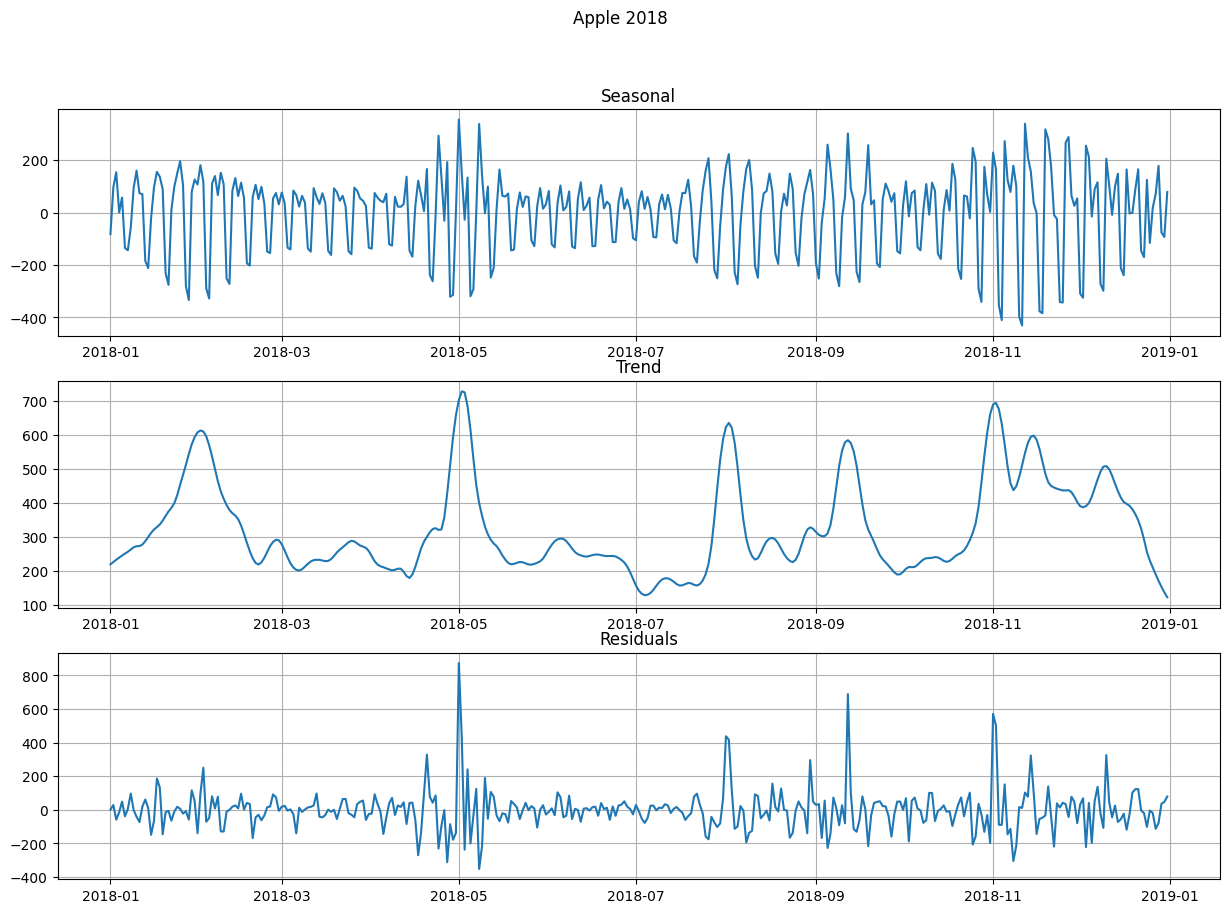

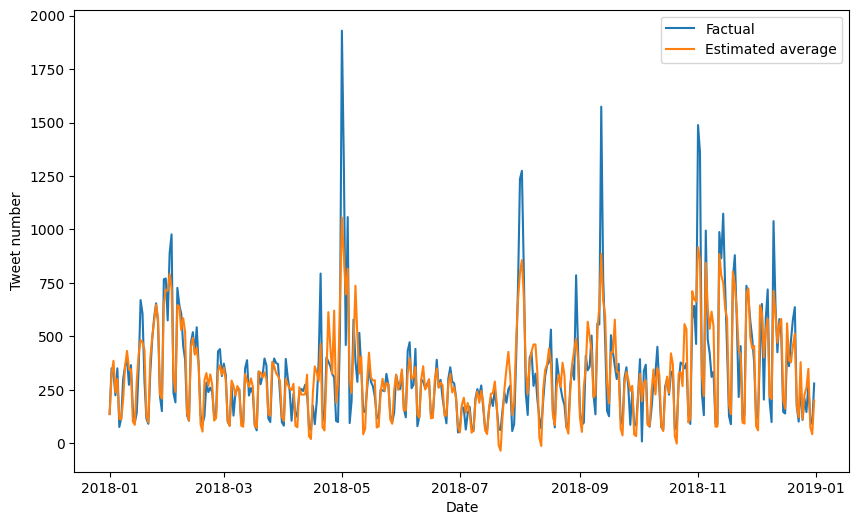

In [109]:
apple_2018 = get_ticker_tweets('AAPL', 2018)
apple_2018_stl = statsmodels.tsa.seasonal.STL(apple_2018)
apple_2018_result = apple_2018_stl.fit()
apple_2018_bounds = get_bounds(apple_2018_result)
apple_estim = apple_2018_result.seasonal + apple_2018_result.trend
make_STL_plot('Apple 2018', apple_2018_result)
make_dev_plot(apple_2018, apple_estim)

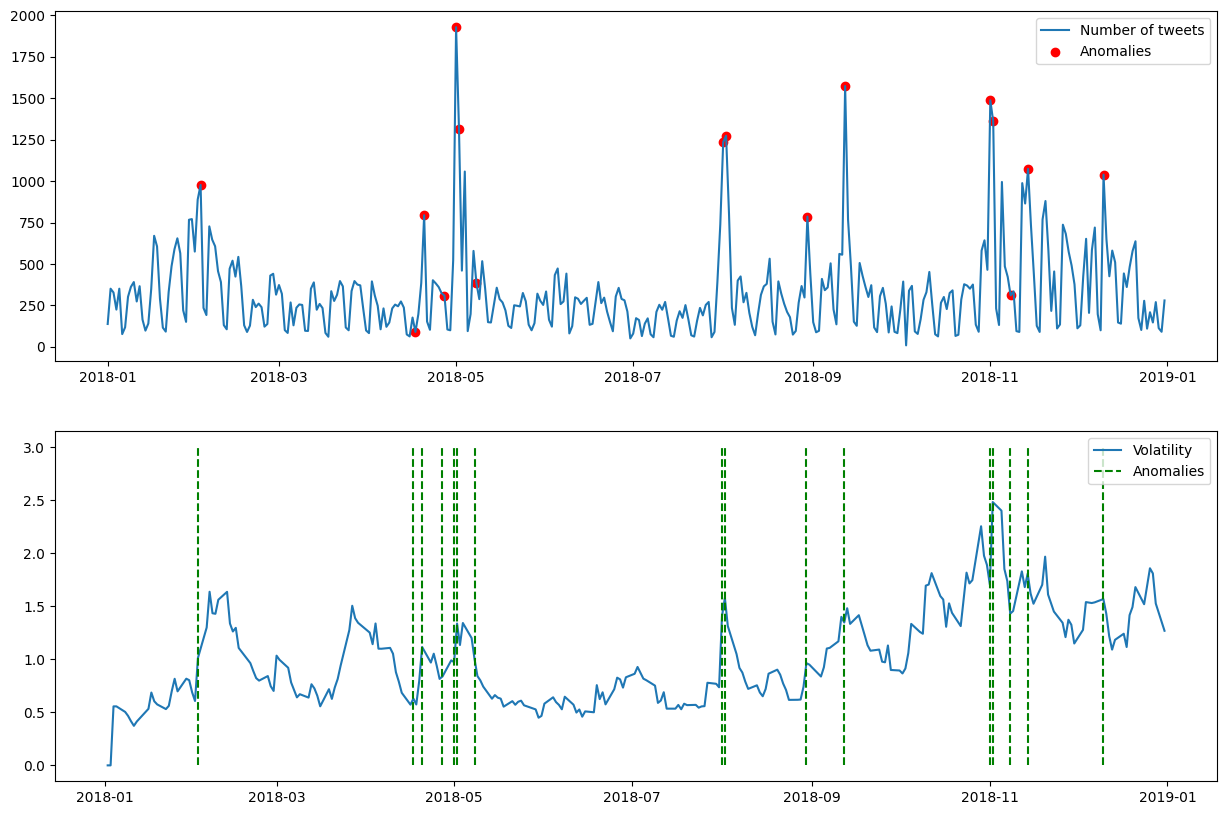

In [110]:
apple_2018_anomalies = get_anomalies(apple_2018, apple_2018_result, apple_2018_bounds)
plot_anomaly(apple_2018, apple_2018_anomalies, AAPL_stock, 2018)

In [111]:
clean_tweets['date'] = pd.to_datetime(clean_tweets.post_date).dt.date

def get_anomaly_tweets(data, anomalies, idx):
    anomaly_dates = anomalies.index
    frame = data[(data.ticker_symbol == 'AAPL')]
    frame = frame[frame.date == anomaly_dates[idx]]
    return frame.sort_values(by='interactions', ascending=False)

In [112]:
sample_1 = get_anomaly_tweets(clean_tweets, apple_2018_anomalies, 0)[['body', 'preprocessed']]
sample_2 = get_anomaly_tweets(clean_tweets, apple_2018_anomalies, 1)[['body', 'preprocessed']]

In [113]:
sample_1[:20]

,body,preprocessed
1448414,Apple beat Samsung in unit sales with iPhone X...,apple beat samsung in unit sales with iphone x...
1447727,To the #bastards at #Apple HQ ... how about pa...,to the bastards at apple hq how about paying a...
1448291,"On @HalftimeReport, I missed an opportunity to...",on halftimereport i missed an opportunity to t...
1448865,Apple hitting oversold conditions in a 14-day ...,apple hitting oversold conditions in a 14 day ...
1449076,Do we like it short? or What? Just adding up t...,do we like it short or what just adding up tot...
1447662,"Even with YoY declines in iPhones sold, Apple ...",even with yoy declines in iphones sold apple s...
1449119,"$AAPL enters correction, but @RiskReversal is ...",enters correction but riskreversal is making a...
1448881,Apple has a 17.5 PE and $160 bil of net cash w...,apple has a 17 5 pe and 160 bil of net cash wh...
1447651,".@vmarks and @thisisneil talk #iOS12 features,...",vmarks and thisisneil talk ios12 features pro ...
1447777,"Apple $AAPL block of 2,500 Jan. 2019 max strik...",apple block of 2 500 jan 2019 max strike 260 c...


In [114]:
sample_2[:20]

,body,preprocessed
1526765,"Here's no question who's on our train, here's ...",here is no question who is on our train here i...
1526928,This is why I am the Big picture expert from t...,this is why i am the big picture expert from t...
1526429,THOSE THAT NEED TO HEDGE HAVE NO SKILL THEY AR...,those that need to hedge have no skill they ar...
1526444,Took a while but happy to close this $AAPL tra...,took a while but happy to close this trade for...
1526480,$FUSZ THE EXCITEMENT WILL BE RAMPING UP INTO...,the excitement will be ramping up into the end...
1526731,$FUSZ on @iHeartRadio CEO Money on @talkradi...,on iheartradio ceo money on talkradio1190 amfe...
1526911,"$AAPL can the airpods, apple music and magazin...",can the airpods apple music and magazine subsc...
1526737,More longs then I've had in weeks and weeks. S...,more longs then i have had in weeks and weeks ...
1526939,SWING TRADE UPDATE! $AAPL Swing entry was brea...,swing trade update swing entry was break of 17...
1526729,Copped some $TWTR $T $DIS $BAC $ETFC $AAPL $AM...,copped some lets see how this goes for earning...


## Semantic similarity

In [115]:
sentence_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [116]:
sample = sample_1.append(sample_2)

In [117]:
# tracker.start()
paraphrases = util.paraphrase_mining(sentence_model, sample.preprocessed.to_list())
# tracker.stop()

In [118]:
diff_sample = []
for i in range(len(paraphrases)):
    if sample.iloc[paraphrases[i][1]].name in sample_1.index and sample.iloc[paraphrases[i][2]].name in sample_2.index:
        diff_sample.append(paraphrases[i])

In [119]:
def semantic_compare(lst, sample, idx):
    print("Sample_1 :",sample.iloc[lst[idx][1]].body)
    print("Sample_2 :",sample.iloc[lst[idx][2]].body)
    print("Score :", lst[idx][0])

At least top 30 semantic similarities are for pregenerated tweets asking to register for the trading app

In [120]:
semantic_compare(diff_sample, sample, 20)

Sample_1 : who fuckss with stocks??? invest guys!! Join @RobinhoodApp and we'll both get a stock like $AAPL, $F, or $S for free. Make sure to use my link.
Sample_2 : Join @RobinhoodApp and we'll both get a stock like $AAPL, $F, or $S for free. Make sure to use my link.https://share.robinhood.com/shaquin3Dm to start investing. It’s free stock...
Score : 0.9139261841773987


Talking about financial situation for a company

In [121]:
semantic_compare(diff_sample, sample, 40)

Sample_1 : (4/n)$AAPL earnings call-"It was another very strong quarter for services with revenue of $8.5 billion, up 18% over last year, and we’re on pace to achieve our goal of doubling our 2016 services revenue by 2020"
Sample_2 : HUGE 10K for $DIRV. Net sales for the year ended December 31, 2017 increased approximately 531% from the comparable period in 2016 $qqq $aapl $tvix $veon $csco $siri $roku $mu $fb $sqqq $intc $cmcsa $amat $nvda $sgmo $wen $aaoi $gpor $qcom $TSLA $ZNGA $MRVL $FOXA $NFLX $FNSR $JD
Score : 0.858220636844635


In [122]:
semantic_compare(diff_sample, sample, 65)

Sample_1 : $AAPL Apple has $250B of cash on hand - says it wants zero net debt so that only leaves $160B to return to shareholders. BUT, it has CFOA of $60B+/yr so that suggests it will return $220B to shareholders in the next 12 months.  Downgrades were pre-written and adjusted to facts.
Sample_2 : $AAPL They won’t, but the easiest thing to do might be (if possible) to pay off all that debt NOW! That way they become a debt free company and don’t have to worry if they only make $30 billion in 2023 and not $50 billion with the debt hanging over them.
Score : 0.8189085721969604


Market sentiment

In [123]:
semantic_compare(diff_sample, sample, 41)

Sample_1 : $AAPL market well off the lows, but this hitting new lows because it never went up when markets bounced. they waited and baited people again
Sample_2 : $aapl trading lower in AH just because of $IBM miss. It always does this but $aapl has no connection to $IBM or earnings. It just gets punished because $IBM is considered Big Tech. Such Bogus.
Score : 0.8495020270347595


Talking about sales

In [124]:
semantic_compare(diff_sample, sample, 55)

Sample_1 : Apple beat Samsung in unit sales with iPhone X during Q4, during the "biggest annual fall in smartphone history" http://dlvr.it/QDmGMP #AppleInsider $AAPL
Sample_2 : iPhone X Responsible for 35% of Total Worldwide Phone Profits in Q4 2017 http://dlvr.it/QPtYnf $AAPL
Score : 0.8341993689537048


## Sentiment analysis

In [125]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

In [126]:
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

In [127]:
def split_dataframe_by_position(df, splits):
    dataframes = []
    index_to_split = len(df) // splits
    start = 0
    end = index_to_split
    for _ in range(splits):
        temporary_df = df.iloc[start:end, :]
        dataframes.append(temporary_df)
        start += index_to_split
        end += index_to_split
    return dataframes

split_dataframes = split_dataframe_by_position(clean_tweets, 22)

In [128]:
len(split_dataframes)

22

In [129]:
if exists('Datasets/results/sentiment_total.pkl'):
    result = pd.read_pickle("Datasets/results/sentiment_total.pkl")
else:
    for i in range(len(split_dataframes)):
        if exists(f'Datasets/results/sentiment/sentiment_{i}.pkl'):
            print(f"Split {i} passed")
            continue
        result = split_dataframes[i].preprocessed.apply(nlp)
        result = pd.DataFrame(result.explode().to_list())
        result.to_pickle(f"Datasets/results/sentiment/sentiment_{i}.pkl")
        print(f"Split {i} completed")

Split 0 passed
Split 1 passed
Split 2 passed
Split 3 passed
Split 4 passed
Split 5 passed
Split 6 passed
Split 7 passed
Split 8 passed
Split 9 passed
Split 10 passed
Split 11 passed
Split 12 passed
Split 13 passed
Split 14 passed
Split 15 passed
Split 16 passed
Split 17 passed
Split 18 passed
Split 19 passed
Split 20 passed
Split 21 passed


### Checking quality

In [130]:
sentiment_check = pd.read_pickle("Datasets/results/sentiment/sentiment_0.pkl")

In [157]:
tweets = pd.read_pickle("Datasets/results/clean_tweets.pkl")

In [158]:
tweets

,tweet_id,post_date,body,preprocessed,interactions
0,550441509175443456,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",lx21 made 10 008 on check it out learn howtotrade,3
1,550441672312512512,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,insanity of today weirdo massive selling bid u...,0
2,550441732014223360,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,s&p100 stocks performance more,74
3,550442977802207232,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,volkswagen pushes 2014 record recall tally hig...,1
4,550444969924653056,2015-01-01 00:14:42,$AAPL Apple goes global with 'Start Something ...,apple goes global with start something new ad ...,1
...,...,...,...,...,...
2548959,1212159275637886976,2019-12-31 23:51:06,"$AAPL yearly~ Heck of a year.. Jan. 2, 1999~ar...",yearly heck of a year jan 2 1999 around 2 3 bu...,1
2548960,1212159765914079234,2019-12-31 23:53:03,That $SPY $SPX puuump in the last hour was the...,that puuump in the last hour was the eoy eoq e...,7
2548961,1212159838882533376,2019-12-31 23:53:21,In 2020 I may start Tweeting out positive news...,in 2020 i may start tweeting out positive news...,1
2548962,1212160015332728833,2019-12-31 23:54:03,Patiently Waiting for the no twitter sitter tw...,patiently waiting for the no twitter sitter tw...,5


In [133]:
sentiment_check_sample = sentiment_check.sample(frac=0.01)

In [134]:
sentiment_check_sample.join(tweets)[['label', 'score', 'preprocessed']].to_csv('examples.csv')

### Combine sentiment

In [174]:
total_sentiment = pd.concat([pd.read_pickle(f'Datasets/results/sentiment/{x}') for x in os.listdir('Datasets/results/sentiment/')]).reset_index().drop(columns='index')

In [175]:
total_sentiment

,label,score
0,Neutral,0.999983
1,Neutral,0.999975
2,Positive,0.829901
3,Positive,0.999979
4,Neutral,0.999981
...,...,...
2548959,Neutral,0.999730
2548960,Positive,0.961279
2548961,Negative,0.871908
2548962,Neutral,0.999870


In [176]:
total_sentiment.to_pickle("Datasets/results/sentiment_total.pkl")

In [177]:
tweets = pd.merge(tweets, total_sentiment, left_index=True, right_index=True)

,tweet_id,post_date,body,preprocessed,interactions,label,score
0,550441509175443456,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",lx21 made 10 008 on check it out learn howtotrade,3,Neutral,0.999983
1,550441672312512512,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,insanity of today weirdo massive selling bid u...,0,Neutral,0.999975
2,550441732014223360,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,s&p100 stocks performance more,74,Positive,0.829901
3,550442977802207232,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,volkswagen pushes 2014 record recall tally hig...,1,Positive,0.999979
4,550444969924653056,2015-01-01 00:14:42,$AAPL Apple goes global with 'Start Something ...,apple goes global with start something new ad ...,1,Neutral,0.999981
...,...,...,...,...,...,...,...
2548959,1212159275637886976,2019-12-31 23:51:06,"$AAPL yearly~ Heck of a year.. Jan. 2, 1999~ar...",yearly heck of a year jan 2 1999 around 2 3 bu...,1,Neutral,0.999730
2548960,1212159765914079234,2019-12-31 23:53:03,That $SPY $SPX puuump in the last hour was the...,that puuump in the last hour was the eoy eoq e...,7,Positive,0.961279
2548961,1212159838882533376,2019-12-31 23:53:21,In 2020 I may start Tweeting out positive news...,in 2020 i may start tweeting out positive news...,1,Negative,0.871908
2548962,1212160015332728833,2019-12-31 23:54:03,Patiently Waiting for the no twitter sitter tw...,patiently waiting for the no twitter sitter tw...,5,Neutral,0.999870


In [155]:
sentiment_counts = total_sentiment.groupby('label').count()
sentiment_counts = sentiment_counts.sort_values(by='score')
sentiment_counts

,score
label,
Negative,293085
Positive,344594
Neutral,1911285


<AxesSubplot: xlabel='label'>

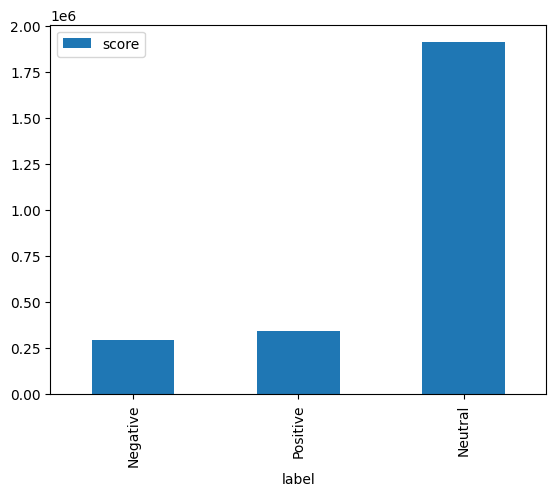

In [156]:
sentiment_counts.plot.bar()